In [1]:
from data_io import load_tiff_files, save_tiff_file, load_config
from metrics_utils import evaluate_predictions, get_tta_predictions
from dataloader_utils import get_dataloaders
import visualization as viz

from itertools import chain
import pandas as pd
import torch
import os

In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [3]:
loose_masks = load_tiff_files('data/bin_nerve_mask')

In [ ]:
models = os.listdir(f"models")
res = {}

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
for experiment_name in models:

    print(f"Processing {experiment_name}...")

    config_path = f"models/{experiment_name}/config.yaml"
    model_path = f"models/{experiment_name}/model.pth"

    if not os.path.exists(config_path):
        print(f"Config file missing for {experiment_name}. Skipping...")
        continue

    transformations = load_config(config_path)
    val_loader = get_dataloaders(mode="val", transform_list=transformations)["val"]

    best_threshold = None
    best_dsc = -1
    best_tpr = -1

    for threshold in thresholds:
        peripherin_marker_input, pred_masks = get_tta_predictions(model_path, val_loader,
                                                                  threshold=threshold,
                                                                  device=device)

        metrics = evaluate_predictions(pred_masks, loose_masks)

        dsc = metrics.get("DSC", 0)
        tpr = metrics.get("TPR", 0)

        print(threshold, dsc, tpr)

        if dsc > best_dsc:
            best_threshold = threshold
            best_dsc = dsc
            best_tpr = tpr

    # Save only results from best threshold
    res[experiment_name] = {
        "best_threshold": best_threshold,
        "DSC": best_dsc,
        "TPR": best_tpr
    }

    print(res[experiment_name])

In [ ]:
df = pd.DataFrame(res).T.reset_index()
df = df.rename(columns={"index": "experiment"})
df.to_csv("results/val_dsc_tpr_scores.csv", index=False)

In [4]:
df = pd.read_csv("results/val_dsc_tpr_scores.csv")

In [5]:
df

experiment  best_threshold       DSC       TPR
0        ci_dice_lr3             0.5  0.597322  0.573410
1       ci_focal_lr3             0.8  0.594494  0.573946
2    ci_mmn_dice_lr3             0.5  0.582253  0.564505
3   ci_mmn_focal_lr3             0.8  0.602219  0.617768
4     ci_mmn_wce_lr3             0.9  0.400117  0.950176
..               ...             ...       ...       ...
58       mmn_wce_lr5             0.9  0.530148  0.748530
59       pn_dice_lr5             0.9  0.271590  0.776856
60      pn_focal_lr5             0.5  0.340548  0.384461
61        pn_wce_lr5             0.6  0.032274  0.031596
62           wce_lr5             0.5  0.032708  0.023196

[63 rows x 4 columns]

In [6]:
df.sort_values(by="DSC", ascending=False).head(15)

experiment  best_threshold       DSC       TPR
32       log_dice_lr4             0.5  0.643072  0.661896
11       log_dice_lr3             0.5  0.636557  0.647027
33      log_focal_lr4             0.8  0.628582  0.724357
54      log_focal_lr5             0.8  0.626585  0.704900
12      log_focal_lr3             0.8  0.612978  0.764879
55        log_wce_lr5             0.9  0.609224  0.655073
22       ci_focal_lr4             0.8  0.604309  0.615282
3    ci_mmn_focal_lr3             0.8  0.602219  0.617768
24   ci_mmn_focal_lr4             0.8  0.598459  0.671700
0         ci_dice_lr3             0.5  0.597322  0.573410
1        ci_focal_lr3             0.8  0.594494  0.573946
21        ci_dice_lr4             0.5  0.591915  0.569150
52  gb_he_mmn_wce_lr5             0.9  0.591213  0.760496
45   ci_mmn_focal_lr5             0.8  0.590009  0.634003
36      mmn_focal_lr4             0.8  0.589050  0.664610

In [7]:
df.sort_values(by="DSC", ascending=False).tail(15)

experiment  best_threshold       DSC       TPR
60        pn_focal_lr5             0.5  0.340548  0.384461
59         pn_dice_lr5             0.9  0.271590  0.776856
19          pn_wce_lr3             0.5  0.186524  0.194584
28           focal_lr4             0.5  0.089160  0.068717
50  gb_he_mmn_dice_lr5             0.9  0.061792  0.988639
48            dice_lr5             0.5  0.061122  0.077014
17         pn_dice_lr3             0.5  0.059823  0.041813
20             wce_lr3             0.5  0.054460  0.047956
7            focal_lr3             0.5  0.046567  0.040962
49           focal_lr5             0.5  0.042348  0.038597
41             wce_lr4             0.5  0.039747  0.027468
62             wce_lr5             0.5  0.032708  0.023196
61          pn_wce_lr5             0.6  0.032274  0.031596
6             dice_lr3             0.5  0.027016  0.018986
27            dice_lr4             0.5  0.024223  0.016537

In [8]:
best_model_name = "log_focal_lr3"
threshold = df[df["experiment"] == best_model_name]["best_threshold"].values[0]
config_path = f"models/{best_model_name}/config.yaml"
losses_path = f"models/{best_model_name}/losses.csv"
model_path = f"models/{best_model_name}/model.pth"

transformations = load_config(config_path)

In [9]:
loaders = get_dataloaders(mode="all", transform_list=transformations)
train_loader, val_loader, test_loader = loaders["train"], loaders["val"], loaders["test"]

In [10]:
# Get predictions for the best model for all datasets
peripherin_marker_input, pred_masks = get_tta_predictions(model_path,
                                                          chain(train_loader, val_loader, test_loader),
                                                          threshold=threshold,
                                                          device=device)

In [11]:
metrics = evaluate_predictions(pred_masks, loose_masks)

In [12]:
metrics

{'DSC': 0.5767396594892399, 'TPR': 0.7231186944800814}

In [13]:
for case_id, pred_mask in pred_masks.items():
    save_tiff_file(f"results/bin_nerve_mask", case_id, pred_mask)

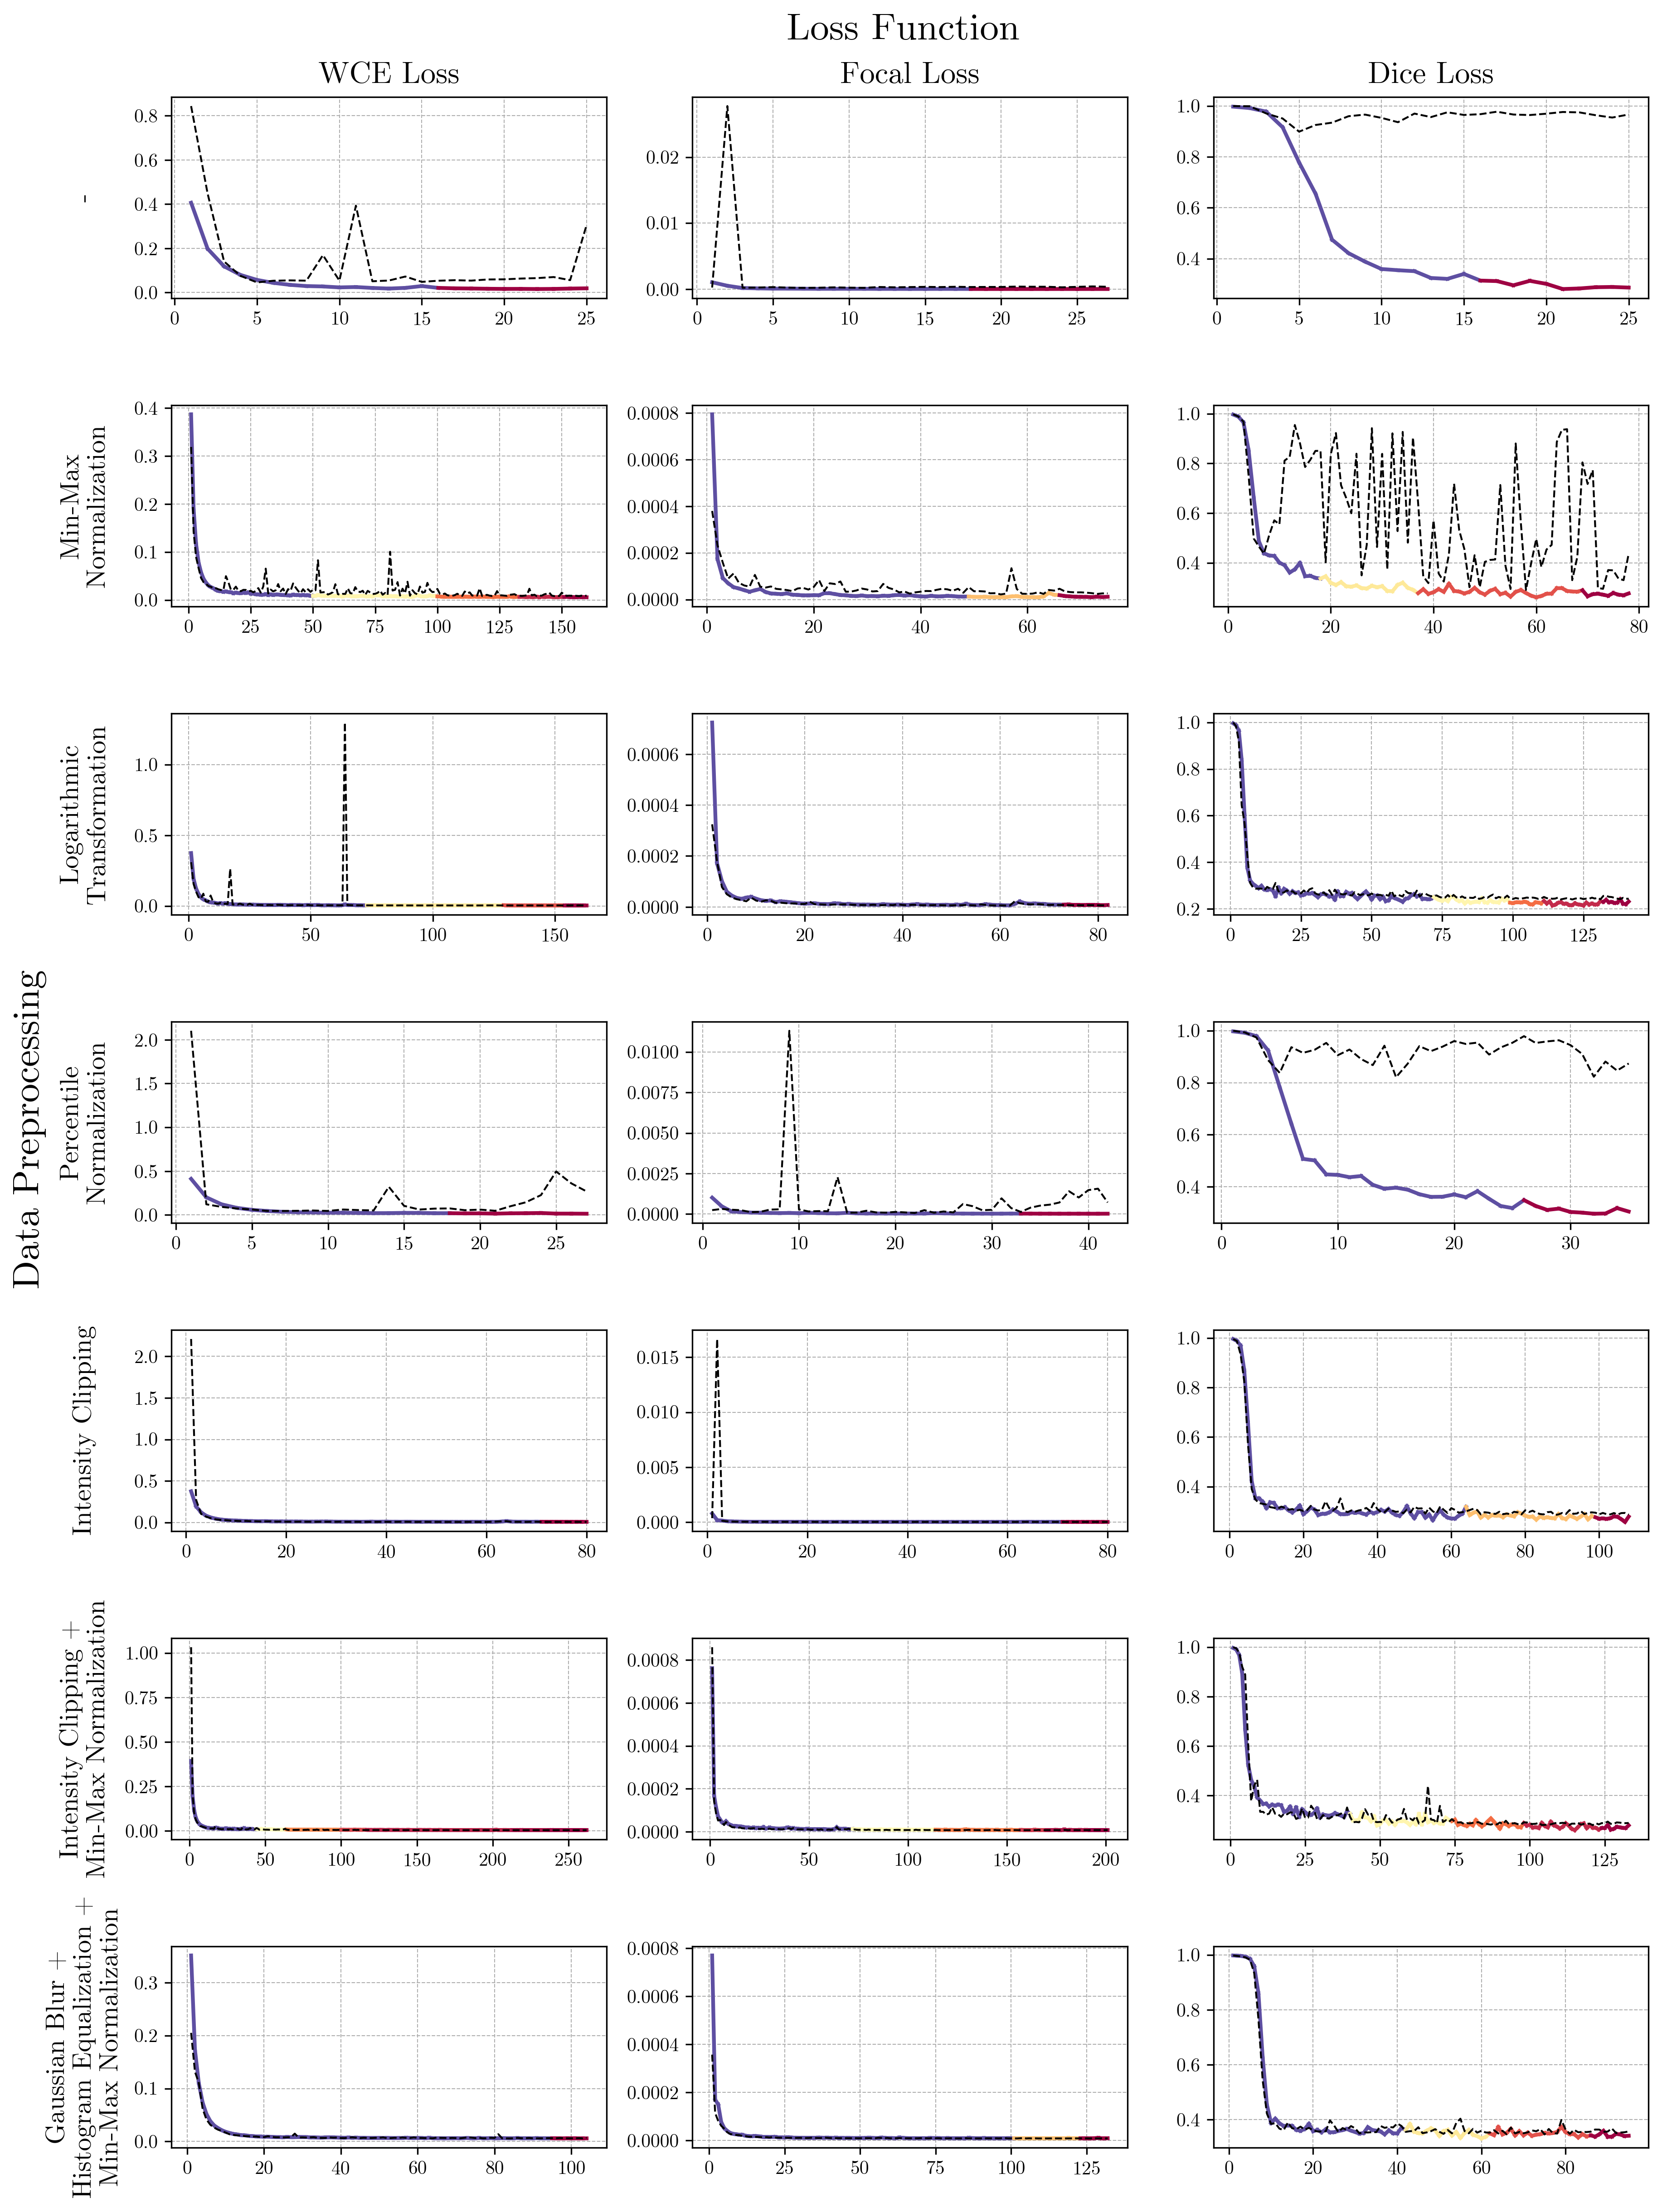

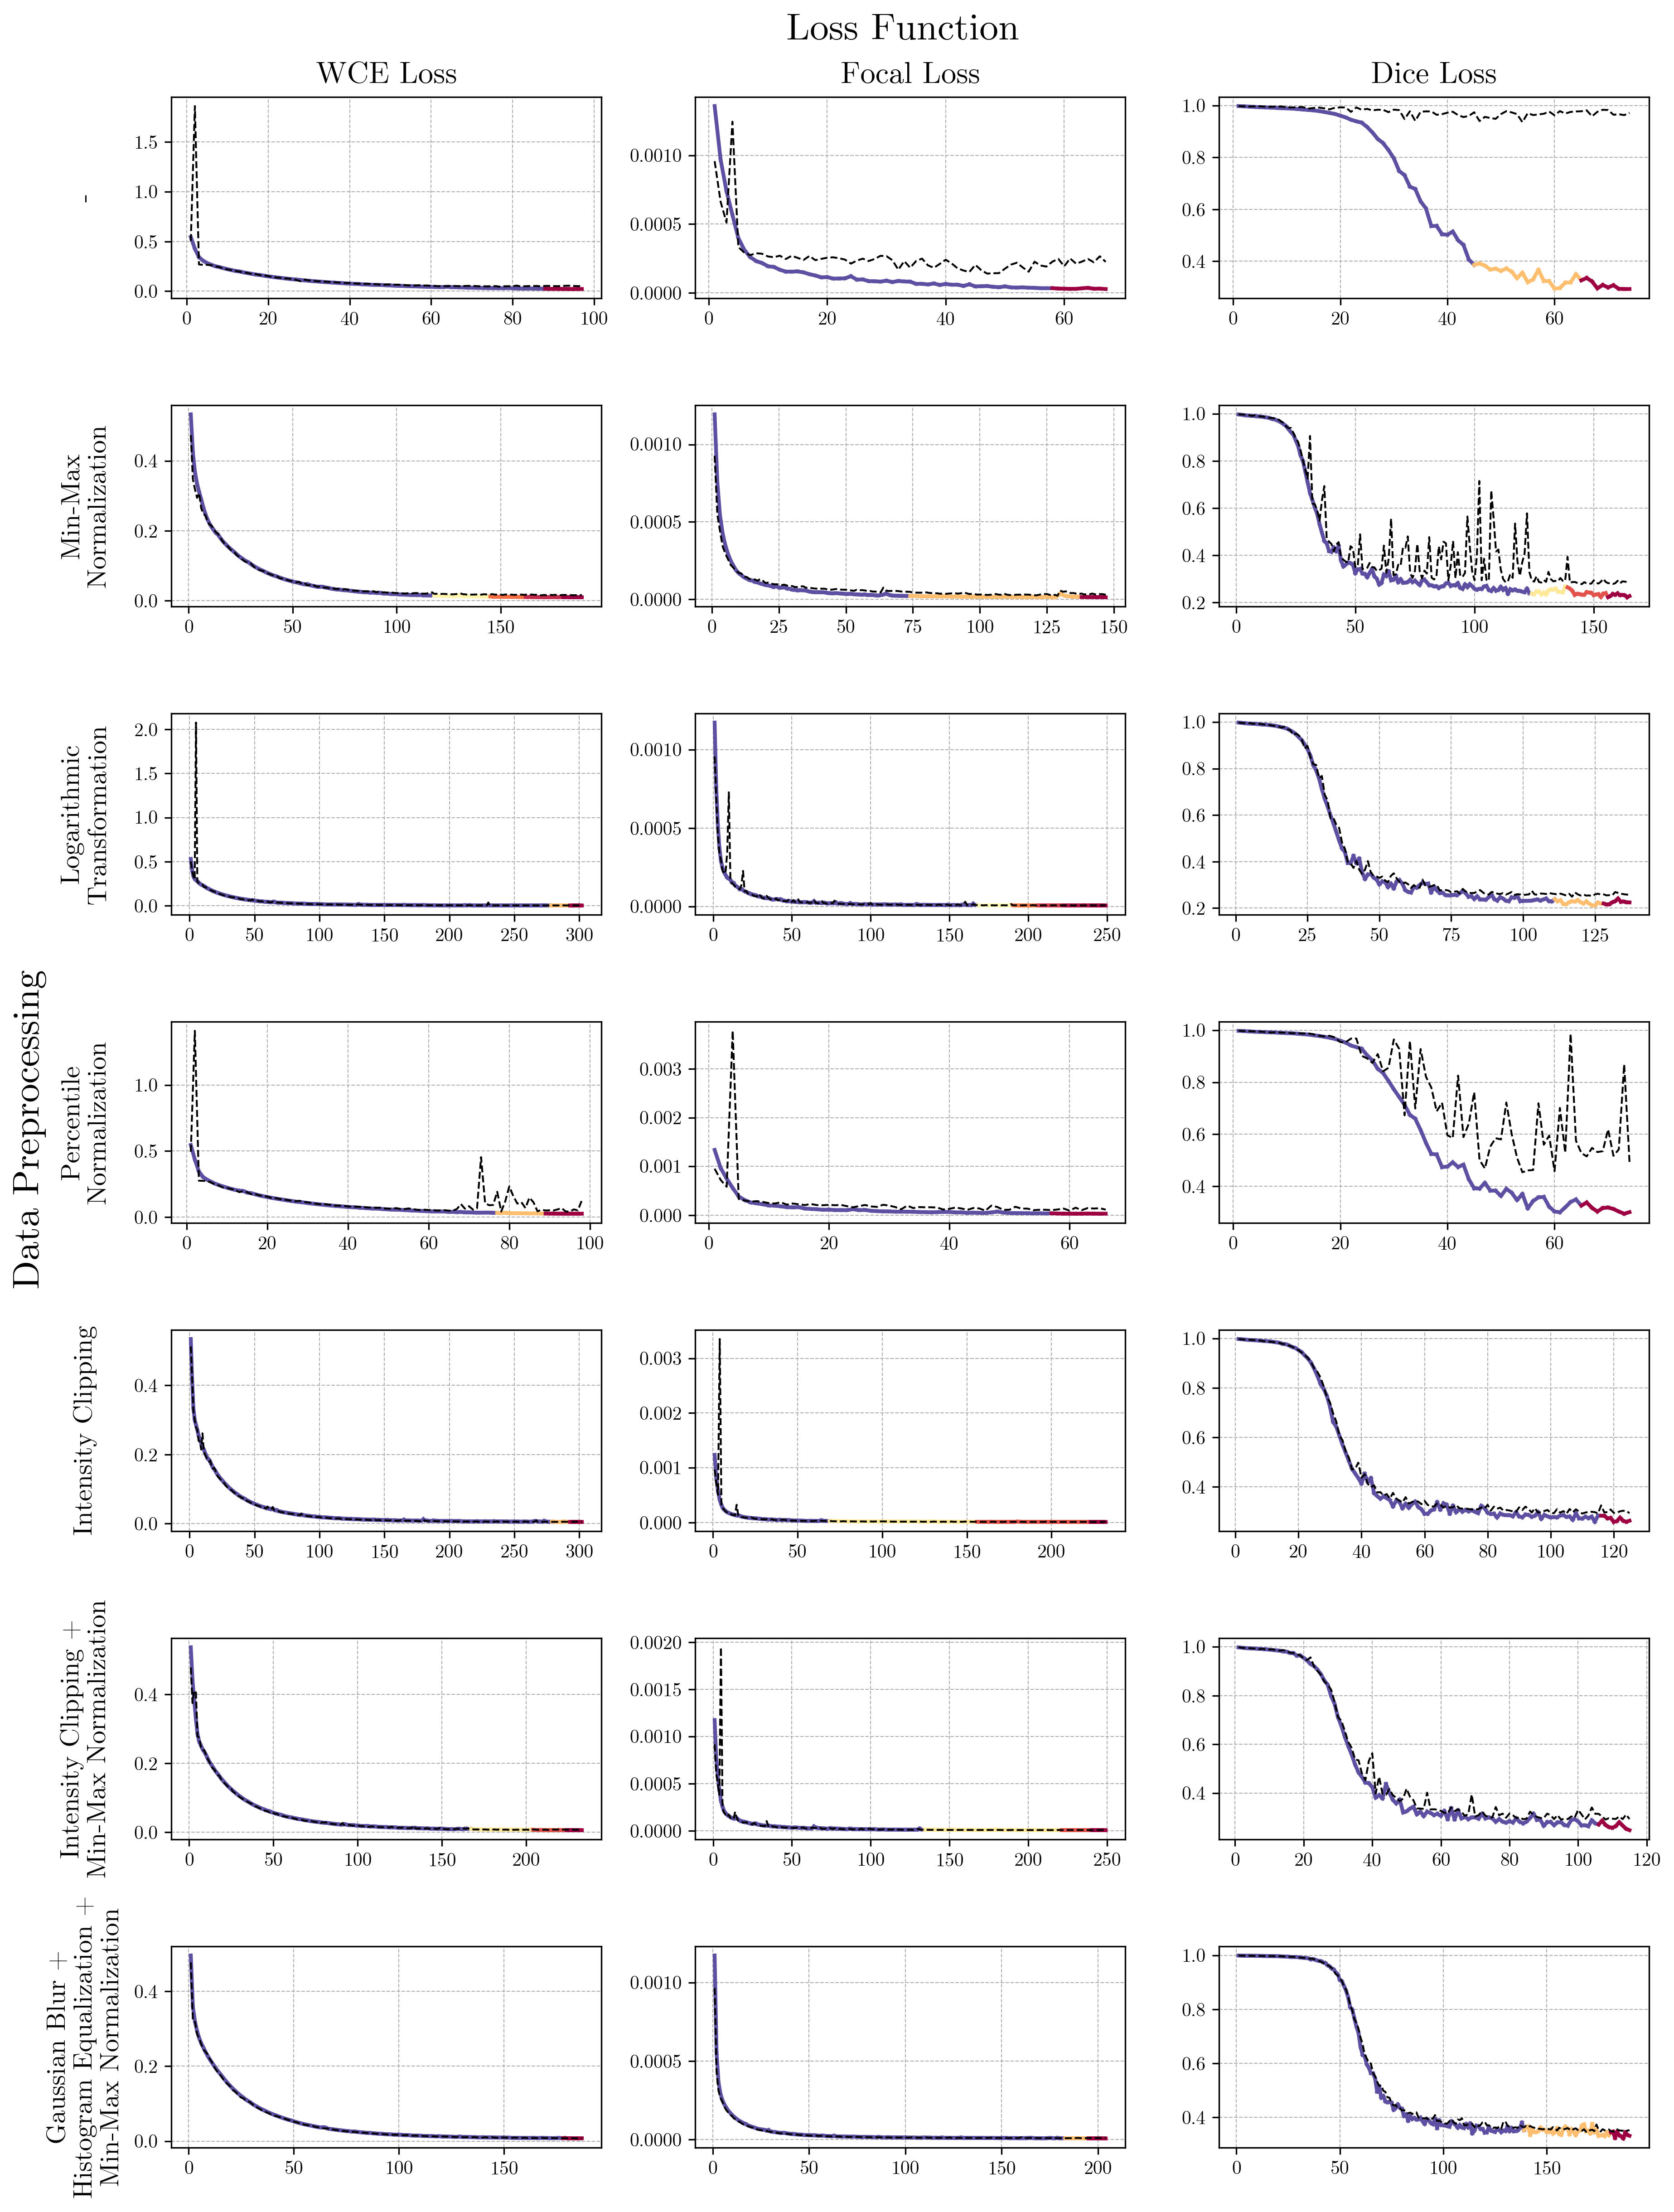

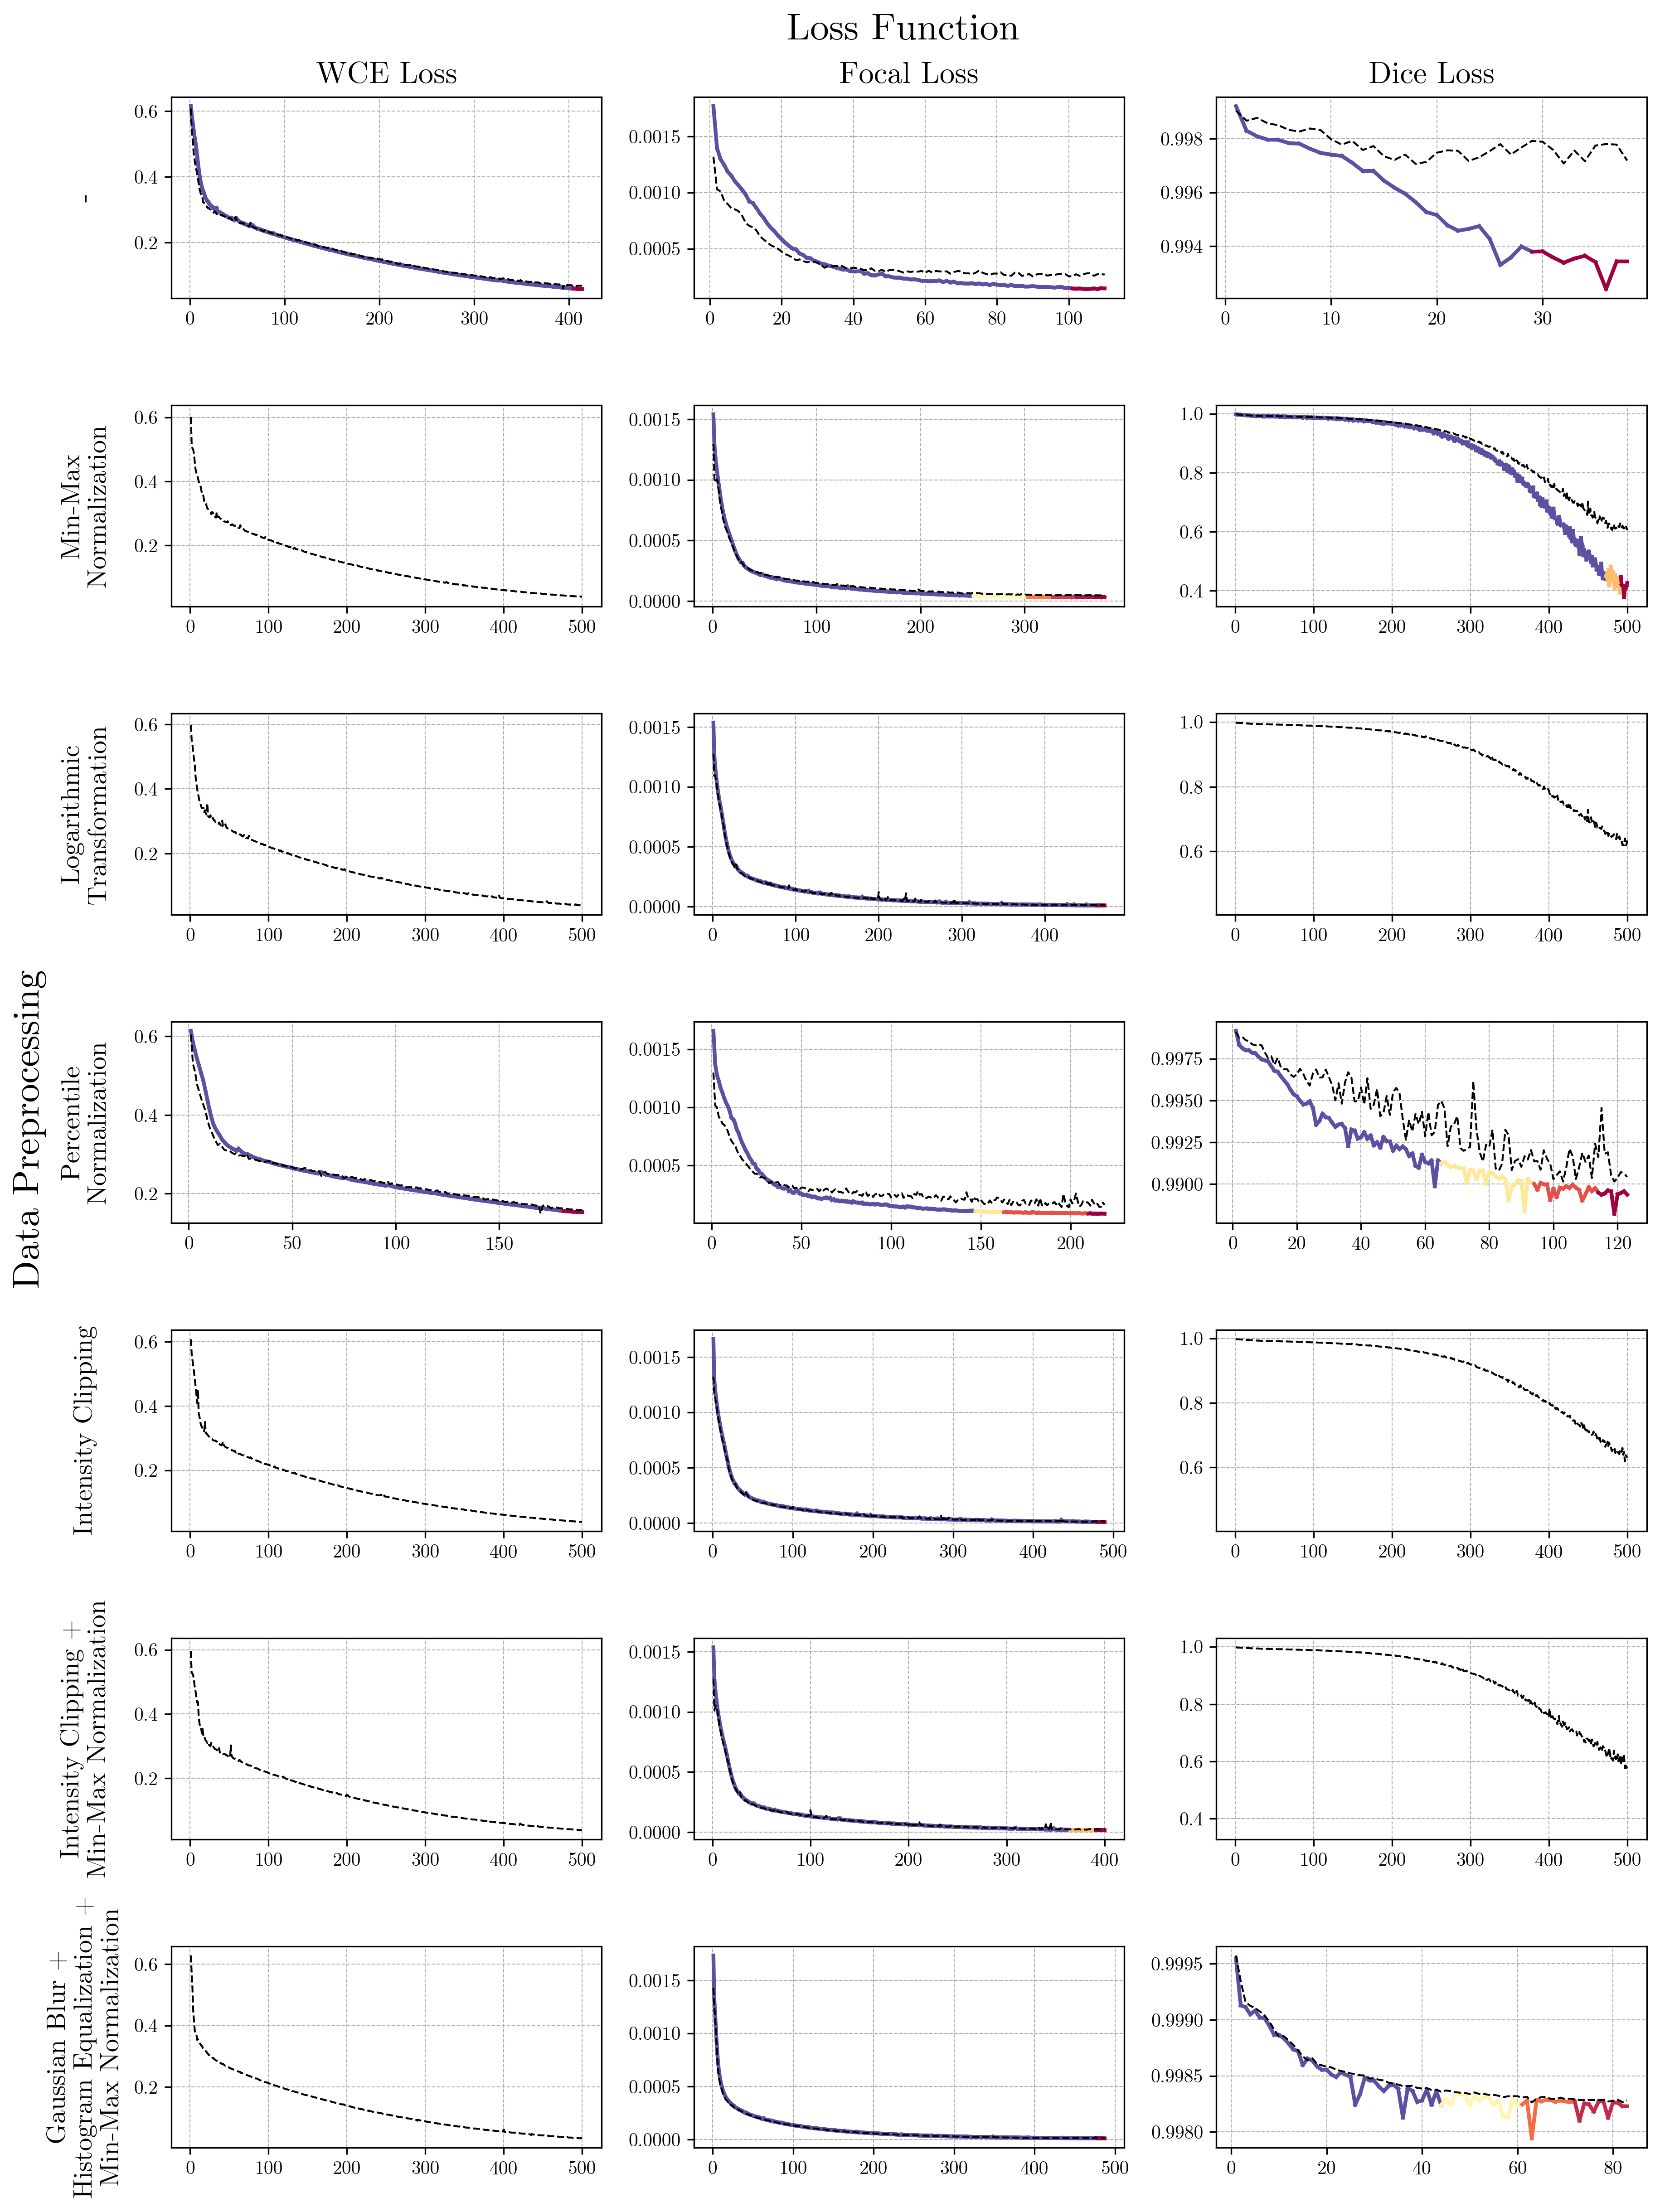

In [14]:
learning_rates = [3, 4, 5]
for lr in learning_rates:
    viz.plot_loss_curves(lr=lr, rows=["-", "mmn", "log", "pn", "ci", "ci_mmn", "gb_he_mmn"],
                         columns=["wce", "focal", "dice"],
                         row_labels=["-", "Min-Max\nNormalization", "Logarithmic\nTransformation",
                                     "Percentile\nNormalization",
                                     "Intensity Clipping", "Intensity Clipping +\nMin-Max Normalization",
                                     "Gaussian Blur +\nHistogram Equalization +\nMin-Max Normalization"],
                         col_labels=["WCE Loss", "Focal Loss", "Dice Loss"])

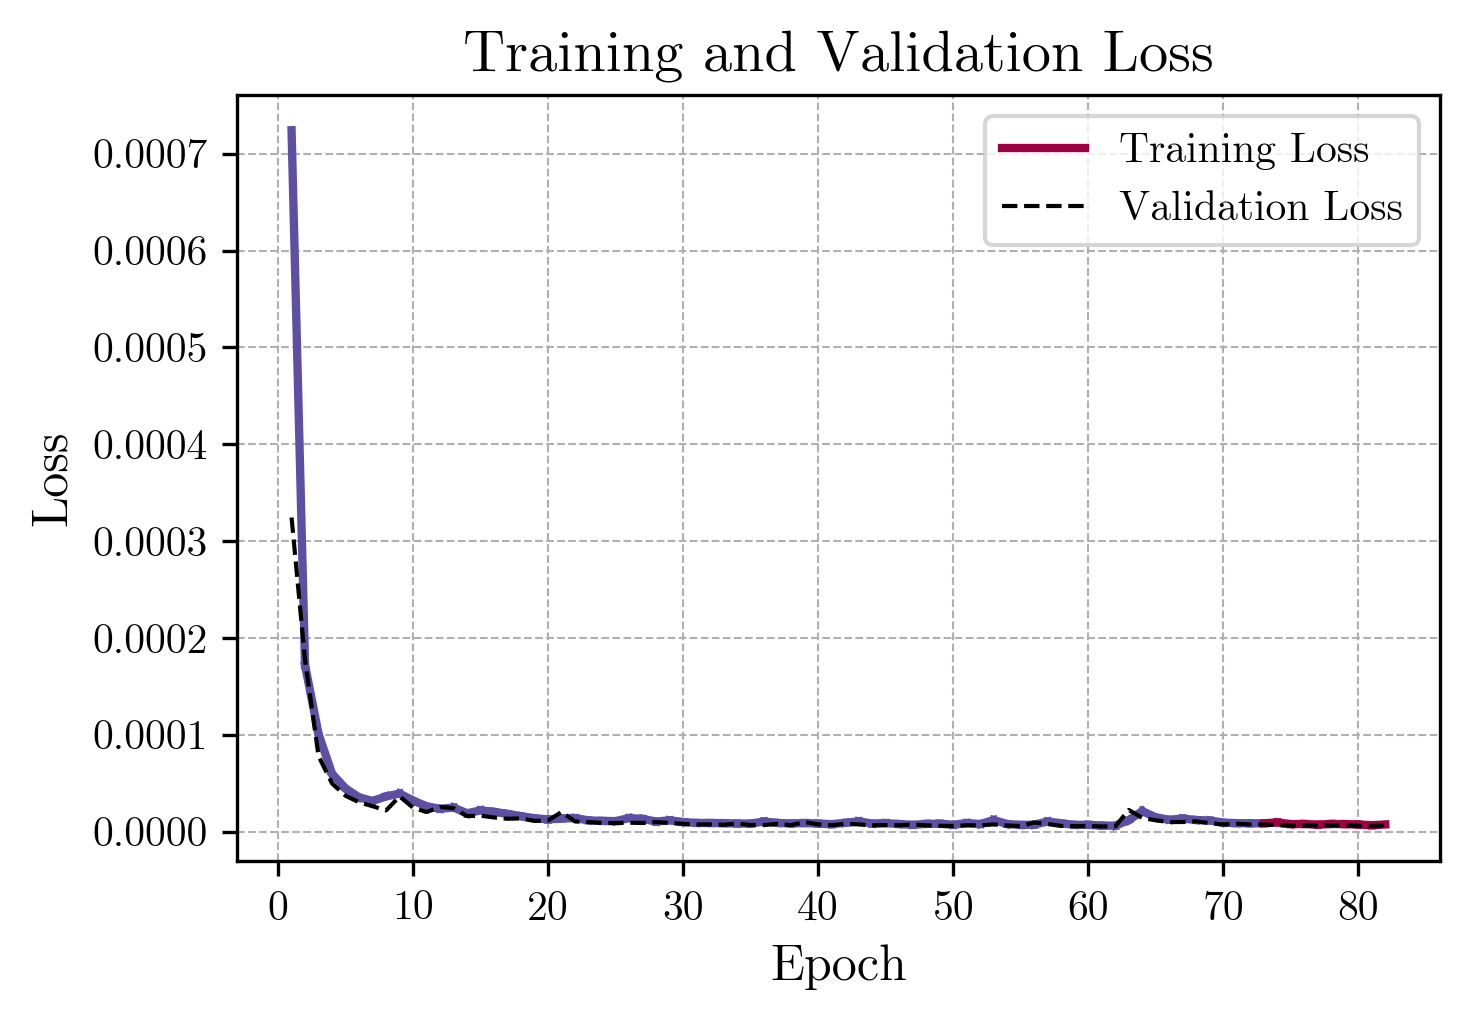

In [15]:
# Loss curve for the best model
viz.plot_loss_curve(losses_path)